In [1]:
import numpy as np
import os, tqdm
import cv2
import librosa
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.metrics import AUC

from skimage.io import imread
from skimage.transform import resize

import audio_v2
from IPython.display import Audio

import warnings
warnings.filterwarnings('ignore')

## Небольшое введение в обработку звука

Звук - вибрации которые опрделяют колебания молекул воздуха, которые в основном создают чередования давления воздуха и это высокое давление чередуется с низким давлением и вызывает волну.

- 1 kHz - 1000 импульсов в секунду

- Период(T) - даёт нам представление о том когда у нас есть тоже самое что и начало у волны (от пика до пика)

- Частота(freq) - обратная функция для периода  =   1 / период. Чем ниже период, тем выше частота

- Амплитуда(A) - расстояние от нулевой точки до пика

$$y(t) = A*sin(2\pi * freq*T + shift)$$

Частота и высота звука связаны друг с другом. Более высокие частоты воспринимаются как более высокая высота.

Большие Амплитуды воспринимаются громче

Так выглядит спектрограмма для мужчин и женчин. Женщины имеют более высокую частоту, так как они имеют более высокий голос

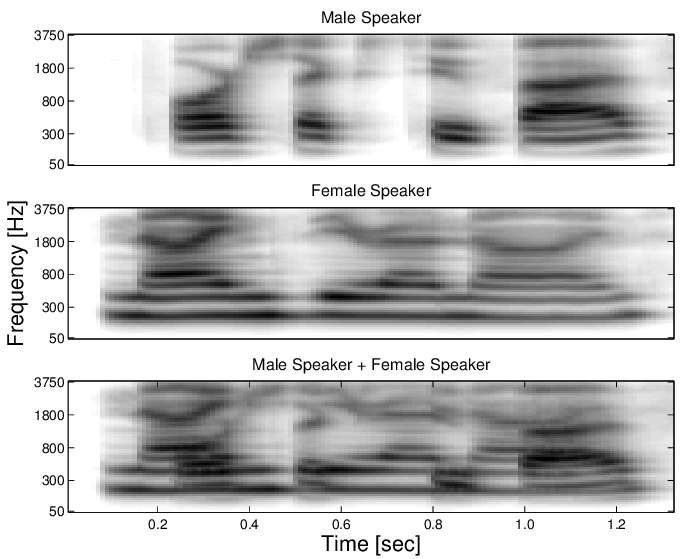

где 
* x - время 
* y - частота
* значения пикселей - амплитуда

In [2]:
# Укажем пути к папкам с песнями
path_like = r'...\wav_audio'
path_dlike = r"...\wav_audio"
path_test = r"...\wav_audio_test"

# Посмотрим на наши данные
like_or_not = audio_v2.Like_or_not(path_like, path_dlike, 22050, 256)
data = like_or_not.get_name_song()                    

data.head()

,song_name,path,target
0,Tanir Tyomcha Потеряли пацана Lyric Video_2,C:\Users\Николай\Conda\project\__Other code__\...,0
1,Everyone You Know - She Don't Dance_6,C:\Users\Николай\Conda\project\__Other code__\...,1
2,Denzel Curry Walkin Official Music Video_5,C:\Users\Николай\Conda\project\__Other code__\...,0
3,Boy Harsher Electric Kris Baha Remix_5,C:\Users\Николай\Conda\project\__Other code__\...,1
4,Jaguar Sun - That Night_0,C:\Users\Николай\Conda\project\__Other code__\...,1


In [3]:
%%time
# Загрузим треки для примера через librosa
librosa_audio, sr = librosa.load(os.path.join(path_like, 'Boy Harsher - R.O.V. (New Beat Edit)_0.wav'), sr=22050)
librosa_audio.shape, sr

CPU times: total: 1.48 s
Wall time: 1.47 s


((661500,), 22050)

Файлы были обрезаны до 30 секунд

In [4]:
# Посмотрим на длинну треков
print(librosa_audio.shape[0] / sr / 60)               

0.5


In [5]:
# Можно прослушать их
display(Audio(data=librosa_audio, rate=sr))

## Получение признаков для бинарной классификации

In [6]:
# Получение признаков
X, y = like_or_not.get_X_y()
display(X.head(3))
display(y.head(3))

 ----- Calculate features ----- 


100%|████████████████████████████████████████████████████████████████████████████████| 470/470 [02:19<00:00,  3.38it/s]


,song_name,path,crossings_zero,rmse,chroma_stft,spec_cent,spec_bw,rolloff,zcr,mfcc_1,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
0,SRTW & Roxy Tones - Please Don't Go (feat. BOK...,C:\Users\Николай\Conda\project\__Other code__\...,1230.400000,0.376551,0.562588,2204.281356,2639.817448,5123.185687,0.055758,-33.446561,...,5.038290,11.763118,6.208458,6.778101,6.677227,10.009863,1.390908,5.414099,0.557797,6.058564
1,Demeter Ya Lame_1,C:\Users\Николай\Conda\project\__Other code__\...,1302.000000,0.342123,0.516614,1762.314263,2168.832498,3776.585497,0.059004,-84.497354,...,0.906846,5.349490,1.046563,5.609791,0.124021,6.109529,1.669344,4.696798,1.371439,2.835860
2,DIARO - Get Ready_4,C:\Users\Николай\Conda\project\__Other code__\...,977.666667,0.367951,0.565528,1808.376762,2307.923341,4166.491472,0.044263,-78.849956,...,7.384728,10.904737,-0.556227,3.831979,-0.552700,7.122708,0.388874,4.727015,3.508842,5.212127


0    1
1    1
2    1
Name: target, dtype: int8

In [7]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Отмасштабируем наши данные
scaler = StandardScaler()

X = scaler.fit_transform(X.drop(["song_name","path"],axis=1).values)
X.shape, y.shape

((470, 27), (470,))

In [8]:
# Сделаем кросс-валидацию и посчитаем точность на простой линейной регрессии
model = LogisticRegression(class_weight='balanced')

cv_score = sklearn.model_selection.cross_val_score(model, X, y, cv=5)
cv_score.mean()

0.7425531914893617

In [9]:
del X, y

Результат не очень, но его можно улучшить подобрав наилучшую модель и параметры для неё. Плюс в выборке всего 69 трэков

## Попробуем улучшить результат с помощью нейронных сетей

В обработке сигналов семплинг — это преобразование непрерывного сигнала в серию дискретных значений. Частота дискретизации — это количество семплов за определенный фиксированный промежуток времени. Высокая частота дискретизации приводит к меньшей потере информации, но к большим вычислительным затратам.


#### Спектральные (частотные) признаки получаются путем преобразования временного сигнала в частотную область с помощью преобразования Фурье

При выборе типа спектра нет точного алгоритма когда какой применять, но можно предположить следующее:
- 'stft' - Short Time Fourier Transform. Оконное преобразование Фурье. 

- 'cqt' - Constant Q-Transform - Преобразование с постоянным Q увеличивает размер окна для низких частот и уменьшая размер окна для высоких частот. Другими словами, преобразование Constant Q даст лучшие результаты в области низких частот и логарифмического отображения частоты, но его крайне сложно заставить работать в реальном времени, и оно имеет немного меньшую детализацию в области верхних частот.

- 'mfcc' - Кепстральные коэффициенты Mel частоты (MFCC) сигнала представляют собой небольшой набор признаков (обычно около 10–20), которые кратко описывают общую форму огибающей спектра. Он моделирует характеристики человеческого голоса.

__Частоты цветности__


Характеристики Chroma - интересное и мощное представление для музыкального аудио, в котором весь спектр проецируется на 12 элементов разрешения, представляющих 12 различных полутонов (или цветность) музыкальной октавы.

Признак или вектор цветности обычно представлен вектором признаков из 12 элементов, в котором указано количество энергии каждого высотного класса {C, C#, D, D#, E, …, B} в сигнале. Используется для описания меры сходства между музыкальными произведениями.

- 'chroma_stft'
- 'chroma_cqt'

### Частотные признаки

In [10]:
# Расчёт stft
D = librosa.stft(librosa_audio)
log_spectrogram = librosa.power_to_db(D**2, ref=np.max)

D.shape

(1025, 1292)

In [11]:
# Constant Q-Transform CQT
CQT = librosa.cqt(librosa_audio)
log_spec_cqt = librosa.power_to_db(np.abs(CQT**2), ref=np.max)

CQT.shape

(84, 1292)

In [12]:
# mfcc
MFCC = librosa.feature.mfcc(y=librosa_audio, sr=sr)
log_spec_mfcc = librosa.power_to_db(np.abs(MFCC**2))

MFCC.shape

(20, 1292)

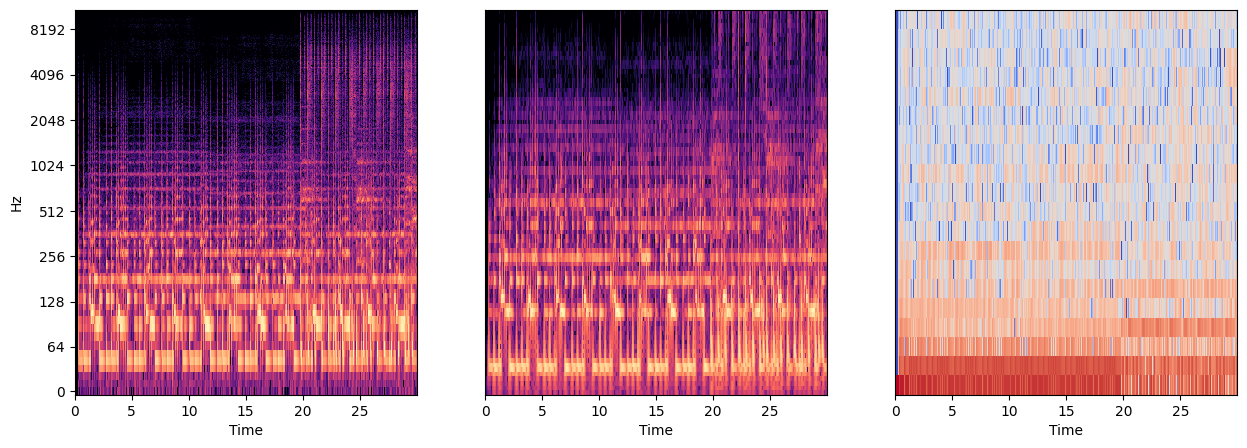

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

librosa.display.specshow(log_spectrogram, x_axis='time', y_axis='log', ax=axes[0]);
librosa.display.specshow(log_spec_cqt, x_axis='time', ax=axes[1]);
librosa.display.specshow(log_spec_mfcc, x_axis='time', ax=axes[2]);

### Частоты цветности

In [14]:
# chroma stft
hop_length = 2048
chromagram = librosa.feature.chroma_stft(y=librosa_audio, sr=sr, hop_length=hop_length)

chromagram.shape

(12, 323)

In [15]:
# chroma CQT
c_cqt = librosa.feature.chroma_cqt(y=librosa_audio, sr=sr)

c_cqt.shape

(12, 1292)

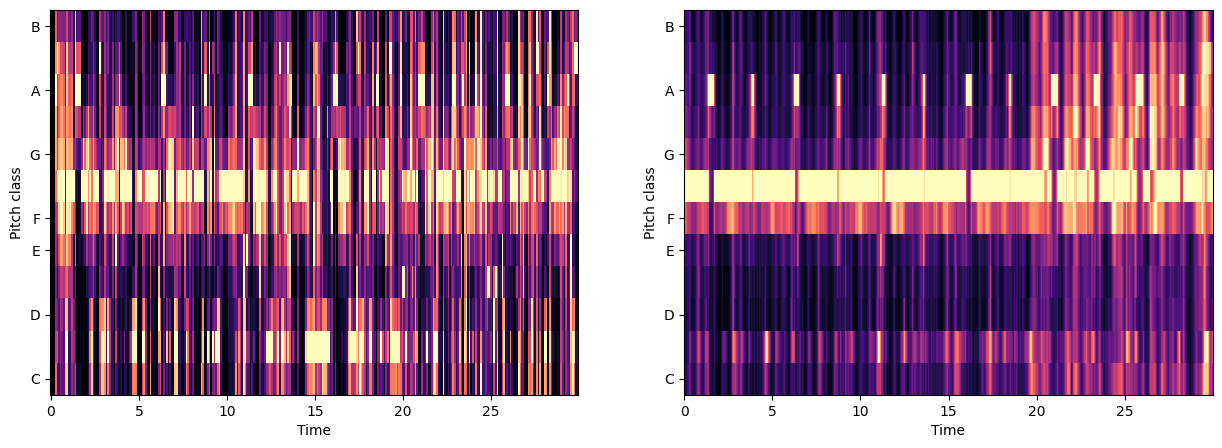

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, ax=axes[0]);  # cmap='cool'
librosa.display.specshow(c_cqt, x_axis='time', y_axis='chroma', ax=axes[1]);

## Подготовим данные для Нейросети

In [17]:
def load_images(photo_path, out_size, gray=False):
    """Функция загружает изображения ...
    Параметры:
      path - путь к папке с изображениями
      out_size - (n_rows, n_cols) - необходимый размер
      gray - открыть изображение как серое или нет
    Возвращет:
      np.array с (n_photo, height, width, channels)
    """
    paths = os.listdir(photo_path)
    n_imgs = len(paths) - 1  # Количество фото в папке - 1 csv

    if gray == False:
        data = np.empty((n_imgs, out_size[0], out_size[1], 3), dtype='float32')  # or dtype=tf.float32 # uint8
    else:
        data = np.empty((n_imgs, out_size[0], out_size[1], 1), dtype='float32')

    # Open imgs and write their in data
    for i, path in tqdm.tqdm(enumerate(paths), total=len(paths)):
        if 'csv' in path:
            target = np.genfromtxt(os.path.join(photo_path, path), delimiter=',')
        else:
            img = imread(os.path.join(photo_path, path), as_gray=gray)
            # Поменяем на нужный размер
            if img.shape != (out_size[0], out_size[1]) or img.shape != (out_size[0], out_size[1], 3):
                img = resize(img, output_shape=(out_size[0], out_size[1]), order=3)  # order is cubic

            if gray == True:
                data[i, :, :, :] = img[:, :, np.newaxis]
            else:
                data[i, :, :, :] = img[:, :, :]

    return data, target

 ----- Saving pictures ----- 


  0%|                                                                                          | 0/470 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▎                                                                                 | 2/470 [00:00<00:38, 12.12it/s]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|▋                                                                                 | 4/470 [00:00<00:35, 13.20it/s]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

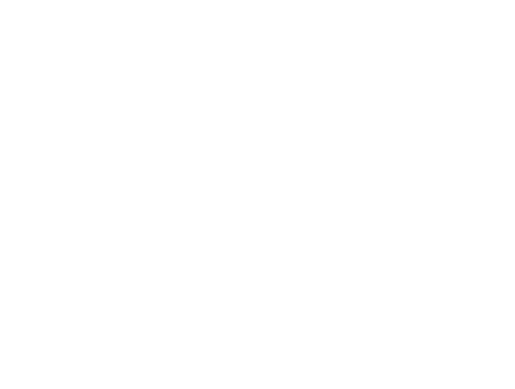

In [18]:
# Сохраним изображения спектрограм для сети в новую папку
out_path = os.path.join(os.getcwd(), 'chroma_stft')
like_or_not.save_img(out_path=out_path, spec='chroma_stft')

# Подготовим тест
out_path_test = os.path.join(os.getcwd(), 'test_chroma_stft')
y_test = like_or_not.prepare_test(in_paths=[os.path.join(path_test, 'Like'),
                                            os.path.join(path_test, 'dLike')],
                                  out_path=out_path_test)

In [19]:
# Загрузим фото
image_shape = (256, 256, 3)

X_train, y_train = load_images(out_path, image_shape)
X_test, y_test = load_images(out_path_test, image_shape)

X_train.shape, X_test.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 13.70it/s]


((470, 256, 256, 3), (54, 256, 256, 3))

In [20]:
# Загрузим модель
base_model = MobileNetV2(input_shape=image_shape, include_top=False, weights=None, pooling='avg')

print(X_test.max(), X_test.min())

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

1.0 0.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_256 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [21]:
# Скомпилируем модель
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=AUC())

# Обучим модель
model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

Epoch 1/2
15/15 [==============================] - 11s 168ms/step - loss: 0.6959 - auc: 0.5073 - val_loss: 0.6914 - val_auc: 0.5000
Epoch 2/2
15/15 [==============================] - 2s 126ms/step - loss: 0.6783 - auc: 0.5219 - val_loss: 0.6881 - val_auc: 0.5000


In [22]:
# Получим предикт
predict = model.predict(X_test[0:1])

predict

1/1 [==============================] - 0s 485ms/step


array([[0.5118775]], dtype=float32)